In [45]:
# a) Import data & info()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
# Load parquet data
df = pd.read_parquet("/content/drive/MyDrive/project-Aug-2023/green_tripdata_2023-08.parquet")  # Replace with your file path
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60649 entries, 0 to 60648
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               60649 non-null  int32         
 1   lpep_pickup_datetime   60649 non-null  datetime64[us]
 2   lpep_dropoff_datetime  60649 non-null  datetime64[us]
 3   store_and_fwd_flag     56769 non-null  object        
 4   RatecodeID             56769 non-null  float64       
 5   PULocationID           60649 non-null  int32         
 6   DOLocationID           60649 non-null  int32         
 7   passenger_count        56769 non-null  float64       
 8   trip_distance          60649 non-null  float64       
 9   fare_amount            60649 non-null  float64       
 10  extra                  60649 non-null  float64       
 11  mta_tax                60649 non-null  float64       
 12  tip_amount             60649 non-null  float64       
 13  t

In [47]:
# b) Drop ehail_fee column
df.drop(columns=['ehail_fee','fare_amount'], inplace=True, errors='ignore')


In [48]:
# c) Calculate trip_duration in minutes
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60


In [49]:
# d) Extract weekday from dropoff datetime
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
print(df['weekday'].value_counts())

weekday
Thursday     10753
Wednesday    10432
Tuesday      10017
Friday        8124
Monday        7730
Saturday      7016
Sunday        6577
Name: count, dtype: int64


In [50]:
# e) Extract hour from dropoff datetime
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
print(df['hourofday'].value_counts())

hourofday
18    4692
17    4405
16    4324
15    4047
19    3985
14    3660
12    3452
13    3316
10    3302
9     3206
11    3202
20    2937
21    2722
8     2661
22    2405
23    1828
7     1789
0     1371
1      879
6      680
2      627
3      427
4      379
5      353
Name: count, dtype: int64


In [51]:
# f) Missing values imputation
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(method='ffill', inplace=True)

<ipython-input-51-dceabe4b6c8c>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


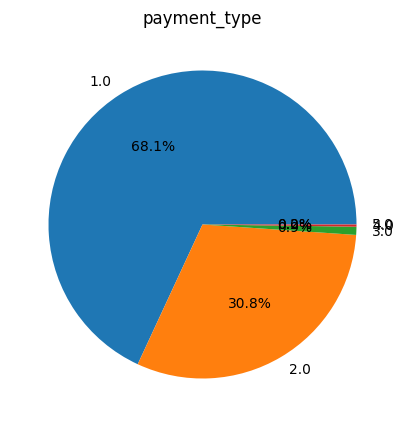

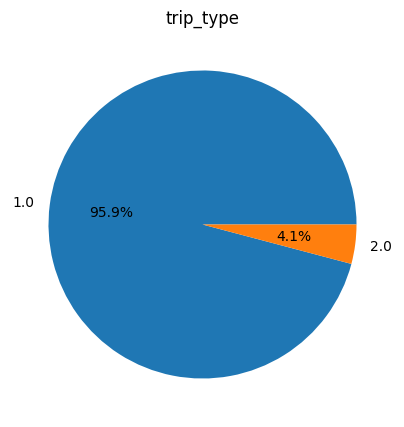

In [52]:
# g) Pie charts
for col in ['payment_type', 'trip_type']:
    df[col].value_counts().plot.pie(autopct='%1.1f%%', title=col, figsize=(5, 5))
    plt.ylabel('')
    plt.show()

In [53]:
# h) Average total_amount by weekday
print(df.groupby('weekday')['total_amount'].mean())

weekday
Friday       24.777927
Monday       25.346444
Saturday     24.716410
Sunday       25.209180
Thursday     25.265622
Tuesday      25.377620
Wednesday    25.469834
Name: total_amount, dtype: float64


In [54]:
# i) Average total_amount by payment_type
print(df.groupby('payment_type')['total_amount'].mean())


payment_type
1.0    27.215720
2.0    21.407183
3.0     5.882287
4.0     5.490511
5.0    30.000000
Name: total_amount, dtype: float64


In [55]:
# j) Average tip_amount by weekday
print(df.groupby('weekday')['tip_amount'].mean())


weekday
Friday       2.328240
Monday       2.364799
Saturday     2.366665
Sunday       2.497052
Thursday     2.504777
Tuesday      2.495436
Wednesday    2.499532
Name: tip_amount, dtype: float64


In [56]:
# k) Average tip_amount by payment_type
print(df.groupby('payment_type')['tip_amount'].mean())

payment_type
1.0    3.589314
2.0    0.000000
3.0    0.000000
4.0    0.000000
5.0    0.000000
Name: tip_amount, dtype: float64


In [57]:
# l) ANOVA: total_amount ~ trip_type
trip_type_groups = [g['total_amount'] for _, g in df.groupby('trip_type')]
print("ANOVA (total_amount ~ trip_type):", f_oneway(*trip_type_groups))


ANOVA (total_amount ~ trip_type): F_onewayResult(statistic=np.float64(2171.0304506979683), pvalue=np.float64(0.0))


In [58]:
# m) ANOVA: total_amount ~ weekday
weekday_groups = [g['total_amount'] for _, g in df.groupby('weekday')]
print("ANOVA (total_amount ~ weekday):", f_oneway(*weekday_groups))


ANOVA (total_amount ~ weekday): F_onewayResult(statistic=np.float64(1.6153684210758328), pvalue=np.float64(0.1382475069825334))


In [59]:
# n) Chi-square test between trip_type and payment_type
contingency = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, _, _ = chi2_contingency(contingency)
print("Chi-square Test:\nChi2 =", chi2, ", p-value =", p)


Chi-square Test:
Chi2 = 211.0810245179477 , p-value = 1.5554379446018303e-44


In [60]:
# o) Numeric columns
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
                'trip_duration', 'passenger_count']


In [65]:
# p) Object columns
object_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type',
               'trip_type', 'weekday', 'hourofday']


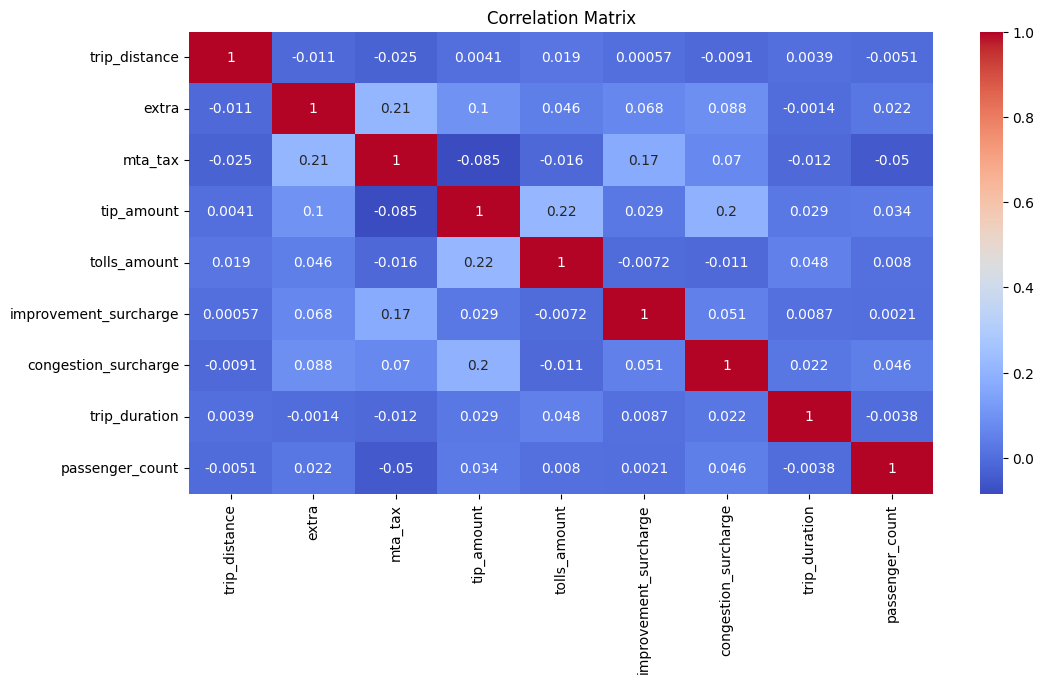

In [66]:
# q) Correlation analysis of numeric cols
# Remove 'fare_amount' from numeric_cols since it was dropped earlier
numeric_cols = ['trip_distance', 'extra', 'mta_tax', 'tip_amount',
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
                'trip_duration', 'passenger_count']

plt.figure(figsize=(12, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [67]:
# r) Dummy encoding of object columns
df_encoded = pd.get_dummies(df, columns=object_cols, drop_first=True)


Text(0.5, 1.0, 'Histogram')

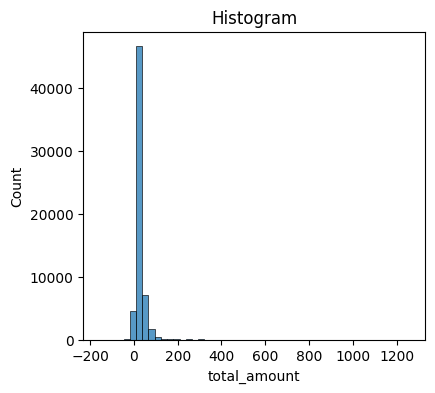

In [68]:
# s) EDA on total_amount
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['total_amount'], bins=50)
plt.title("Histogram")

Text(0.5, 1.0, 'Boxplot')

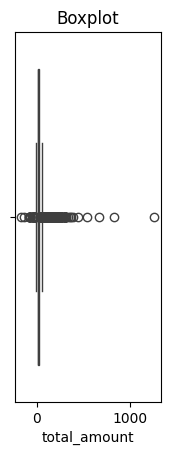

In [69]:
plt.subplot(1, 3, 2)
sns.boxplot(x=df['total_amount'])
plt.title("Boxplot")


Text(0.5, 1.0, 'Density Curve')

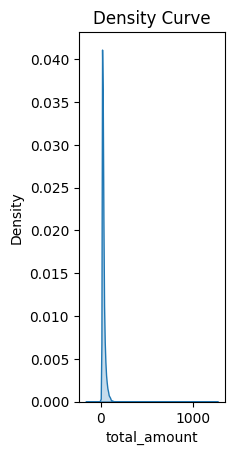

In [70]:
plt.subplot(1, 3, 3)
sns.kdeplot(df['total_amount'], fill=True)
plt.title("Density Curve")


In [71]:
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [72]:
# t) Regression Models
X = df_encoded.drop(columns=['total_amount'])
y = df_encoded['total_amount']
# t) Regression Models
X = df_encoded.drop(columns=['total_amount'])
y = df_encoded['total_amount']


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [74]:
# Drop datetime columns if present
datetime_cols = df_encoded.select_dtypes(include=['datetime64']).columns
df_encoded = df_encoded.drop(columns=datetime_cols)


In [75]:
X = df_encoded.drop(columns=['total_amount'])
y = df_encoded['total_amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Linear Regression R²:", r2_score(y_test, lr.predict(X_test)))


Linear Regression R²: 0.43683745297231047


In [77]:
# 2. Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
print("Decision Tree R²:", r2_score(y_test, dt.predict(X_test)))

Decision Tree R²: 0.6551220093473658


In [78]:
# 3. Random Forest (100 trees)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest R²:", r2_score(y_test, rf.predict(X_test)))

Random Forest R²: 0.8538929714156295


In [79]:
# 4. Gradient Boosting (100 trees)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
print("Gradient Boosting R²:", r2_score(y_test, gb.predict(X_test)))

Gradient Boosting R²: 0.7827181146932584
